In [1]:
from functools import partial
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pathlib import Path
import matplotlib.pyplot as plt
from CIFARLoader import save_cifar_fit, check_cifar
import easydict 


In [2]:
VALIDATION_SPLIT = 0.1

train_datagen = ImageDataGenerator(
    featurewise_center=True, 
    samplewise_center=False,
    featurewise_std_normalization=True, 
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rescale= 1./255, 
    rotation_range=40, 
    width_shift_range=0.2, 
    height_shift_range= 0.2, 
    shear_range= 0.2, 
    zoom_range=0.2, 
    horizontal_flip=True, 
    fill_mode='nearest', 
    validation_split=VALIDATION_SPLIT
)


test_datagen = ImageDataGenerator()

In [3]:
OUTPUT_DIR = 'cifar10_data'

In [4]:
args = easydict.EasyDict({
    "dataset": "cifar10",
    "output": "cifar10_data",
    "name_with_batch_index": False
})

# check_output_path(args.output)

if check_cifar(args.dataset):
    save_cifar_fit(args, train_datagen)


                      /-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|

Saving train images: 100%|██████████| 50000/50000 [00:18<00:00, 2659.33it/s]


                     /-\|/-\|/-\|/

Saving test images: 100%|██████████| 10000/10000 [00:03<00:00, 2605.95it/s]


In [5]:
import glob

IMAGE_COUNT = len(glob.glob(OUTPUT_DIR + '/' + 'train'  + '/*/*'))

print(IMAGE_COUNT)

50000


In [6]:
BATCH_SIZE = 100

STEPS_PER_EPOCH = np.ceil((IMAGE_COUNT - IMAGE_COUNT * VALIDATION_SPLIT)/BATCH_SIZE)

IMAGE_COUNT, STEPS_PER_EPOCH

(50000, 500.0)

In [7]:
TARGET_SIZE = (227, 227)

train_generator = train_datagen.flow_from_directory(
    OUTPUT_DIR + '/' + 'train', 
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE, 
    class_mode='categorical', 
    subset='training',
    shuffle=True,
    seed=42
)
validation_generator = train_datagen.flow_from_directory(
    OUTPUT_DIR + '/' + 'train',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=42
)
train_datagen.standardize
test_generator = test_datagen.flow_from_directory(
    OUTPUT_DIR + '/' + 'test', target_size=TARGET_SIZE)




Found 45000 images belonging to 10 classes.
Found 5000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


Alexnet

In [8]:
DefaultAlexConv2D = partial(keras.layers.Conv2D, strides=(4, 4) , activation = tf.nn.relu)
DefaultAlexMaxPool2D = partial(keras.layers.MaxPool2D, padding = 'SAME', data_format='channels_last')
DefaultBatchNormalize = partial(tf.keras.layers.BatchNormalization)
DefaultDropout = partial(tf.keras.layers.Dropout, rate = 0.5)

In [9]:
from datetime import datetime

date_time = datetime.now().strftime("%m_%d_%Y_%H_%M_%S")

alex_net_model = keras.models.Sequential([
    DefaultAlexConv2D(filters=96, kernel_size=(11, 11),
                      input_shape=(227, 227, 3), padding='VALID'),
    DefaultBatchNormalize(),
    DefaultAlexMaxPool2D(pool_size=(3, 3)), 
    DefaultAlexConv2D(filters = 256, kernel_size = (5, 5), padding = 'SAME'),
    DefaultBatchNormalize(),
    DefaultAlexMaxPool2D(pool_size=(3, 3)), 
    DefaultAlexConv2D(filters = 384, kernel_size = (3, 3),  padding = 'SAME'),
    DefaultBatchNormalize(),
    DefaultAlexConv2D(filters = 384, kernel_size = (3, 3),  padding = 'SAME'),
    DefaultBatchNormalize(),
    DefaultAlexConv2D(filters = 256, kernel_size = (3, 3),  padding = 'SAME'),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation=tf.nn.relu),
    DefaultDropout(),
    keras.layers.Dense(4096, activation=tf.nn.relu),
    DefaultDropout(),
    keras.layers.Dense(10, activation=tf.nn.softmax)
    ], name="alex_net_model_" + date_time)

In [10]:
alex_net_model.summary()

Model: "alex_net_model_02_02_2022_23_25_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 55, 55, 96)        384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 19, 19, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 256)         614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 5, 256)         1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 256)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (No

In [11]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,_,logs={}):
        if (logs.get("accuracy")==0.98 and logs.get("loss")<0.03):
            print("\nReached 98% accuracy so stopping training")
            self.model.stop_training =True
callbacks = myCallback()

In [12]:
alex_net_model.compile(loss=tf.losses.CategoricalCrossentropy(), metrics=[
                       'accuracy'], optimizer=tf.optimizers.Adam(learning_rate=0.0001))

history = alex_net_model.fit(train_generator,validation_data=validation_generator,
    callbacks=[callbacks], verbose=2, workers=16, 
    epochs=50, steps_per_epoch=STEPS_PER_EPOCH)


Epoch 1/50
500/500 - 84s - loss: 1.6536 - accuracy: 0.3925 - val_loss: 1.5933 - val_accuracy: 0.4222
Epoch 2/50
500/500 - 64s - loss: 1.4255 - accuracy: 0.4849 - val_loss: 1.3578 - val_accuracy: 0.5156
Epoch 3/50
500/500 - 64s - loss: 1.3375 - accuracy: 0.5205 - val_loss: 1.3072 - val_accuracy: 0.5350
Epoch 4/50
500/500 - 65s - loss: 1.2738 - accuracy: 0.5421 - val_loss: 1.3512 - val_accuracy: 0.5294
Epoch 5/50
500/500 - 64s - loss: 1.2396 - accuracy: 0.5573 - val_loss: 1.1839 - val_accuracy: 0.5814
Epoch 6/50
500/500 - 64s - loss: 1.1940 - accuracy: 0.5739 - val_loss: 1.1846 - val_accuracy: 0.5792
Epoch 7/50
500/500 - 65s - loss: 1.1630 - accuracy: 0.5830 - val_loss: 1.1934 - val_accuracy: 0.5672
Epoch 8/50
500/500 - 65s - loss: 1.1316 - accuracy: 0.5980 - val_loss: 1.1081 - val_accuracy: 0.6082
Epoch 9/50
500/500 - 65s - loss: 1.1156 - accuracy: 0.6008 - val_loss: 1.1699 - val_accuracy: 0.5912
Epoch 10/50
500/500 - 65s - loss: 1.1016 - accuracy: 0.6077 - val_loss: 1.1145 - val_accura

In [13]:
score = alex_net_model.evaluate(test_generator, workers=16,verbose=2)

313/313 - 6s - loss: 67581.9453 - accuracy: 0.1000


Training accuracy:  0.6962599754333496
Training loss:  0.8999549150466919
Validation accuracy:  0.6890000104904175
Validation loss:  0.9343875050544739


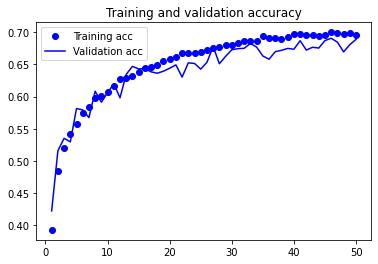

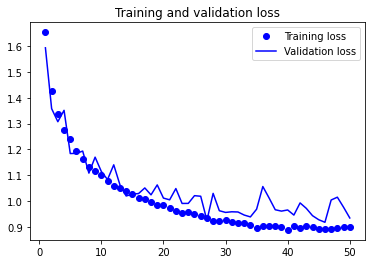

In [14]:

acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]

print("Training accuracy: ", acc)
print("Training loss: ", loss)

print("Validation accuracy: ", val_acc)
print("Validation loss: ", val_loss)

# Plotting the graphs to visualize the trend of accuracy and loss

epochs = range(1, len(history.history['accuracy'])+1)

plt.plot(epochs, history.history['accuracy'], 'bo', label='Training acc')
plt.plot(epochs, history.history['val_accuracy'], 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, history.history['loss'], 'bo', label='Training loss')
plt.plot(epochs, history.history['val_loss'], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [15]:
alex_net_model.save('alex_net_model_' + date_time + '.h5')
